Libraries imported successfully
[START] TRAINING ENSEMBLE MODELS WITH 10-FOLD CV
[INFO] Data loaded successfully from classification_processed_data
   Training samples: 436
   Test samples: 110
[INFO] Loaded hyperparameters for 6 base models

[ENSEMBLE] TRAINING ENSEMBLE MODELS WITH 10-FOLD CV

[CREATE] Creating ensemble models...
[INFO] Bagging: 15 Random Forests with 70% samples
[INFO] Boosting: 150 estimators, LR=0.05, depth=4
[INFO] XGBoost: 150 estimators, LR=0.05, depth=4
[INFO] Selective Stacking: Using only top 3 performing base models:
   - RANDOM FOREST
   - SVM
   - DECISION TREE
[INFO] Weighted Voting: RF(2.0), SVM(1.5), DT(1.0)

[MODEL] Training BAGGING with 10-fold CV on TRAINING SET ONLY...
   > CV Accuracy: 0.5779 (+/- 0.0536)
   > Test Accuracy: 0.5182
   > AUC-ROC: 0.5392

[MODEL] Training BOOSTING with 10-fold CV on TRAINING SET ONLY...
   > CV Accuracy: 0.5801 (+/- 0.0579)
   > Test Accuracy: 0.4909
   > AUC-ROC: 0.5094

[MODEL] Training XGBOOST with 10-fold CV on T

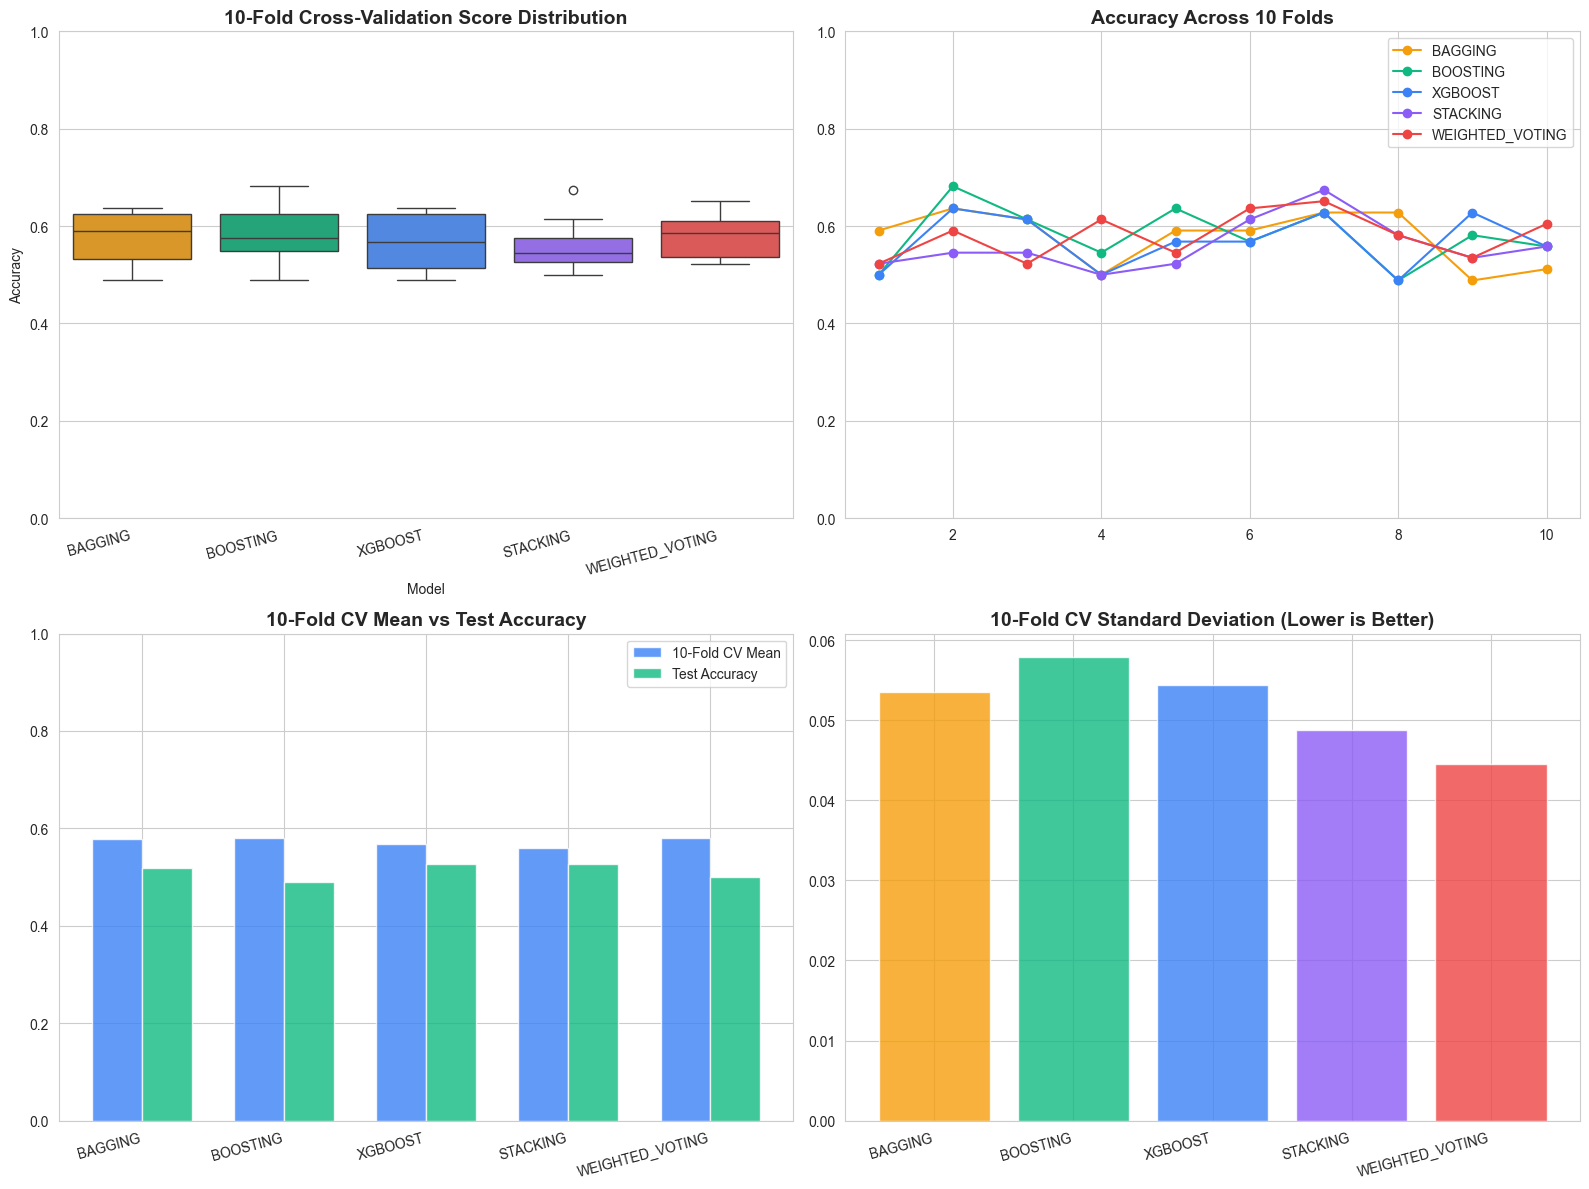


[SAVE] Ensemble models saved to saved_classification_ensemble_models/


In [6]:
# Cell 1: Imports and Setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import json
import joblib
import warnings
import sys

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier, BaggingClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc

from xgboost import XGBClassifier

warnings.filterwarnings('ignore')

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 8)

print("Libraries imported successfully")

# Cell 2: Define EnsembleModels Class
class EnsembleModels:
    def __init__(self, best_params_dict=None):
        self.best_params = best_params_dict or {}
        self.ensemble_models = {}
        self.y_test = None
        
    def create_bagging_ensemble(self):
        bagging = BaggingClassifier(
            estimator=RandomForestClassifier(
                n_estimators=100,
                max_depth=15,
                min_samples_split=5,
                random_state=42
            ),
            n_estimators=15,
            max_samples=0.7,
            max_features=0.9,
            bootstrap=True,
            random_state=42,
            n_jobs=-1
        )
        self.ensemble_models['bagging'] = bagging
        print("[INFO] Bagging: 15 Random Forests with 70% samples")
        return bagging
    
    def create_boosting_ensemble(self):
        boosting = GradientBoostingClassifier(
            n_estimators=150,
            learning_rate=0.05,
            max_depth=4,
            min_samples_split=5,
            subsample=0.8,
            random_state=42
        )
        self.ensemble_models['boosting'] = boosting
        print("[INFO] Boosting: 150 estimators, LR=0.05, depth=4")
        return boosting

    def create_xgboost_ensemble(self):
        xgboost_model = XGBClassifier(
            n_estimators=150,
            learning_rate=0.05,
            max_depth=4,
            subsample=0.8,
            colsample_bytree=0.9,
            use_label_encoder=False,
            eval_metric='logloss',
            random_state=42,
            n_jobs=-1
        )
        self.ensemble_models['xgboost'] = xgboost_model
        print("[INFO] XGBoost: 150 estimators, LR=0.05, depth=4")
        return xgboost_model
    
    def create_stacking_ensemble(self):
        rf_params = self.best_params.get('random_forest', {'n_estimators': 100, 'max_depth': 15})
        svm_params = self.best_params.get('svm', {'C': 1.0, 'kernel': 'rbf', 'gamma': 'scale'})
        dt_params = self.best_params.get('decision_tree', {'max_depth': 10, 'min_samples_split': 5})
        
        estimators = [
            ('random_forest', RandomForestClassifier(random_state=42, **rf_params)),
            ('svm', SVC(probability=True, random_state=42, **svm_params)),
            ('decision_tree', DecisionTreeClassifier(random_state=42, **dt_params))
        ]
        
        print(f"[INFO] Selective Stacking: Using only top 3 performing base models:")
        for name, _ in estimators:
            print(f"   - {name.replace('_', ' ').upper()}")
        
        stacking = StackingClassifier(
            estimators=estimators,
            final_estimator=LogisticRegression(random_state=42, max_iter=1000),
            cv=5,
            n_jobs=-1
        )
        self.ensemble_models['stacking'] = stacking
        return stacking

    def create_weighted_voting_ensemble(self):
        rf_params = self.best_params.get('random_forest', {'n_estimators': 100, 'max_depth': 15})
        svm_params = self.best_params.get('svm', {'C': 1.0, 'kernel': 'rbf', 'gamma': 'scale'})
        dt_params = self.best_params.get('decision_tree', {'max_depth': 10, 'min_samples_split': 5})
        
        estimators = [
            ('random_forest', RandomForestClassifier(random_state=42, **rf_params)),
            ('svm', SVC(probability=True, random_state=42, **svm_params)),
            ('decision_tree', DecisionTreeClassifier(random_state=42, **dt_params))
        ]
        
        voting = VotingClassifier(
            estimators=estimators,
            voting='soft',
            weights=[2, 1.5, 1],
            n_jobs=-1
        )
        
        self.ensemble_models['weighted_voting'] = voting
        print("[INFO] Weighted Voting: RF(2.0), SVM(1.5), DT(1.0)")
        return voting
    
    def train_ensemble_models_with_10fold(self, X_train, y_train, X_test, y_test):
        print("\n" + "="*60)
        print("[ENSEMBLE] TRAINING ENSEMBLE MODELS WITH 10-FOLD CV")
        print("="*60)
        
        self.y_test = y_test
        results = {}
        
        cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
        
        print("\n[CREATE] Creating ensemble models...")
        self.create_bagging_ensemble()
        self.create_boosting_ensemble()
        self.create_xgboost_ensemble()
        self.create_stacking_ensemble()
        self.create_weighted_voting_ensemble()
        
        for name, model in self.ensemble_models.items():
            print(f"\n[MODEL] Training {name.upper()} with 10-fold CV on TRAINING SET ONLY...")
            
            fold_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='accuracy', n_jobs=-1)
            
            cv_mean = np.mean(fold_scores)
            cv_std = np.std(fold_scores)
            cv_min = np.min(fold_scores)
            cv_max = np.max(fold_scores)
            
            model.fit(X_train, y_train)
            
            y_pred = model.predict(X_test)
            y_pred_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None
            
            test_accuracy = accuracy_score(y_test, y_pred)
            
            auc_roc = 0
            if y_pred_proba is not None:
                fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
                auc_roc = auc(fpr, tpr)
            
            results[name] = {
                'accuracy': test_accuracy,
                'cv_10fold_mean': cv_mean,
                'cv_10fold_std': cv_std,
                'cv_10fold_min': cv_min,
                'cv_10fold_max': cv_max,
                'cv_10fold_scores': fold_scores.tolist(),
                'auc_roc': auc_roc,
                'classification_report': classification_report(y_test, y_pred, output_dict=True),
                'confusion_matrix': confusion_matrix(y_test, y_pred).tolist(),
                'y_pred': y_pred,
                'y_pred_proba': y_pred_proba
            }
            
            print(f"   > CV Accuracy: {cv_mean:.4f} (+/- {cv_std:.4f})")
            print(f"   > Test Accuracy: {test_accuracy:.4f}")
            print(f"   > AUC-ROC: {auc_roc:.4f}")

        self._save_results_to_json(results, 'ensemble_comparison/ensemble_models_results.json')
        
        return results
    
    def _save_results_to_json(self, results, filepath):
        os.makedirs(os.path.dirname(filepath), exist_ok=True)
        
        class NumpyEncoder(json.JSONEncoder):
            def default(self, obj):
                if isinstance(obj, np.integer):
                    return int(obj)
                if isinstance(obj, np.floating):
                    return float(obj)
                if isinstance(obj, np.ndarray):
                    return obj.tolist()
                return super(NumpyEncoder, self).default(obj)

        json_results = {}
        for name, result in results.items():
            json_results[name] = {k: v for k, v in result.items() 
                                if k not in ['y_pred', 'y_pred_proba', 'confusion_matrix']}
        
        with open(filepath, 'w') as f:
            json.dump(json_results, f, indent=2, cls=NumpyEncoder)
        
        print(f"[SAVED] Ensemble results saved to {filepath}")

    def visualize_10fold_results(self, results, output_dir='ensemble_comparison'):
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)
        
        sns.set_style("whitegrid")
        
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        
        model_names = list(results.keys())
        colors = ['#f59e0b', '#10b981', '#3b82f6', '#8b5cf6', '#ef4444'] 
        
        fold_data = []
        for name in model_names:
            for fold_idx, score in enumerate(results[name]['cv_10fold_scores'], 1):
                fold_data.append({
                    'Model': name.upper(),
                    'Fold': fold_idx,
                    'Accuracy': score
                })
        
        fold_df = pd.DataFrame(fold_data)
        
        sns.boxplot(x='Model', y='Accuracy', data=fold_df, ax=axes[0, 0], palette=colors[:len(model_names)])
        axes[0, 0].set_xticklabels([name.upper() for name in model_names], rotation=15, ha='right')
        axes[0, 0].set_title('10-Fold Cross-Validation Score Distribution', fontsize=14, fontweight='bold')
        axes[0, 0].set_ylim([0.0, 1.0])
        
        for idx, name in enumerate(model_names):
            model_data = fold_df[fold_df['Model'] == name.upper()]
            axes[0, 1].plot(model_data['Fold'], model_data['Accuracy'], marker='o', 
                           label=name.upper(), color=colors[idx % len(colors)])
        
        axes[0, 1].set_title('Accuracy Across 10 Folds', fontsize=14, fontweight='bold')
        axes[0, 1].legend()
        axes[0, 1].set_ylim([0.0, 1.0])
        
        x = np.arange(len(model_names))
        width = 0.35
        
        cv_means = [results[name]['cv_10fold_mean'] for name in model_names]
        test_accs = [results[name]['accuracy'] for name in model_names]
        
        axes[1, 0].bar(x - width/2, cv_means, width, label='10-Fold CV Mean', color='#3b82f6', alpha=0.8)
        axes[1, 0].bar(x + width/2, test_accs, width, label='Test Accuracy', color='#10b981', alpha=0.8)
        
        axes[1, 0].set_title('10-Fold CV Mean vs Test Accuracy', fontsize=14, fontweight='bold')
        axes[1, 0].set_xticks(x)
        axes[1, 0].set_xticklabels([name.upper() for name in model_names], rotation=15, ha='right')
        axes[1, 0].legend()
        axes[1, 0].set_ylim([0.0, 1.0])
        
        cv_stds = [results[name]['cv_10fold_std'] for name in model_names]
        axes[1, 1].bar([name.upper() for name in model_names], cv_stds, color=colors[:len(model_names)], alpha=0.8)
        axes[1, 1].set_title('10-Fold CV Standard Deviation (Lower is Better)', fontsize=14, fontweight='bold')
        axes[1, 1].set_xticklabels([name.upper() for name in model_names], rotation=15, ha='right')
        
        plt.tight_layout()
        plt.show()
        
    def print_10fold_summary(self, results):
        print("\n" + "="*90)
        print("ENSEMBLE 10-FOLD CROSS-VALIDATION SUMMARY")
        print("="*90)
        
        print(f"\n{'Model':<20} {'CV Mean':<12} {'CV Std':<12} {'CV Min':<12} {'CV Max':<12} {'Test Acc':<12}")
        print("-"*90)
        
        sorted_results = sorted(results.items(), key=lambda x: x[1]['cv_10fold_mean'], reverse=True)
        
        for name, result in sorted_results:
            print(f"{name.upper():<20} {result['cv_10fold_mean']:.4f}       {result['cv_10fold_std']:.4f}       {result['cv_10fold_min']:.4f}       {result['cv_10fold_max']:.4f}       {result['accuracy']:.4f}")

# Cell 3: Load Data and Run Training

DATA_DIR = 'classification_processed_data'
RESULTS_FILE = 'model_comparison/base_models_results.json'

print("="*60)
print("[START] TRAINING ENSEMBLE MODELS WITH 10-FOLD CV")
print("="*60)

try:
    X_train = np.load(os.path.join(DATA_DIR, 'X_train_label.npy'))
    X_test = np.load(os.path.join(DATA_DIR, 'X_test_label.npy'))
    y_train = np.load(os.path.join(DATA_DIR, 'y_train.npy'))
    y_test = np.load(os.path.join(DATA_DIR, 'y_test.npy'))
    print(f"[INFO] Data loaded successfully from {DATA_DIR}")
    print(f"   Training samples: {X_train.shape[0]}")
    print(f"   Test samples: {X_test.shape[0]}")
except Exception as e:
    print(f"[ERROR] Could not load data: {e}")
    raise e

best_params = {}
if os.path.exists(RESULTS_FILE):
    try:
        with open(RESULTS_FILE, 'r') as f:
            results_data = json.load(f)
            for model_name, model_data in results_data.items():
                if 'best_params' in model_data:
                    best_params[model_name] = model_data['best_params']
        print(f"[INFO] Loaded hyperparameters for {len(best_params)} base models")
    except Exception as e:
        print(f"[WARNING] Error loading results file: {e}")
else:
    print("[WARNING] No base model results file found, using default hyperparameters")

ensemble = EnsembleModels(best_params_dict=best_params)
ensemble_results = ensemble.train_ensemble_models_with_10fold(X_train, y_train, X_test, y_test)

ensemble.print_10fold_summary(ensemble_results)

# Cell 4: Visualize Results and Save Models

print(f"\n[VISUALIZATION] Creating 10-fold CV analysis...")
ensemble.visualize_10fold_results(ensemble_results)

SAVE_DIR = 'saved_classification_ensemble_models'
if not os.path.exists(SAVE_DIR):
    os.makedirs(SAVE_DIR)

for name, model in ensemble.ensemble_models.items():
    joblib.dump(model, os.path.join(SAVE_DIR, f'{name}_ensemble.pkl'))

print(f"\n[SAVE] Ensemble models saved to {SAVE_DIR}/")